# Introduction
In this notebook, we follow chapter 2 of the [fastai book](https://github.com/fastai/fastbook). Chapter 2 presents a fairly general method for making an accurate image classifier. The book specifically shows how to build a classifier to distinguish grizzly bears from black bears from teddy bears. It goes through all of the main steps of the process, from building a dataset to filtering and formatting the images to deploying the resulting model as a simple notebook-based application.

In this notebook, I will closely follow the approach laid out in chapter 2 to make a turtle classifier. I plan to make a classifier that will be able to distinguish:
* American softshell turtle
* Painted Turtle
* Box turtle
* (any kind of ) Tortoise.

This loosely parallels the book's example. Painted tutles and box turtles are probably the most likely to be confused. Softshell turtles and tortoises look considerably different, so I would assume they will be relatively easy to distinguish from each other and from the other types of turtles.

# Gathering Data
We use the bing image search API to collect our data. I started by making a free-tier account using the Azure Cognitive Searches Bing Search V7 API.

The book asks us to put our API key in plain text. I don't want to do that, in part because I'm not entirely clear on the payment policies of Azure, and I don't want to expose an API key that can later be used by others. So I've created a `.env` file with my API key and added it to my `.gitignore`. In the next step, we retrieve it and save it as `key`.

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

key = os.getenv('AZURE_API_KEY')

## Searching Images
Next, we use our newly-set-up Bing image search functionality to make a dataset. Let's look at the documentation.

In [9]:
from fastai import * # Not "Pythonic", but it's what they say to do!
from fastbook import *
from fastai.vision.widgets import *

doc(search_images_bing)

In [10]:
results = search_images_bing(key, 'Apalone spinifera')
ims = results.attrgot('content_url')
len(ims)

150

In [11]:
ims[2]

'http://www.louisianaherps.com/_Media/dsc00017.jpeg'

In [12]:
dest = 'images/softshell.jpeg'
download_url(ims[1], dest)

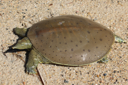

In [13]:
im = Image.open(dest)
im.to_thumb(128,128)

### Collecting Images of Different Types of Turtles

In [18]:
turtle_types = 'Apalone spinifera', 'Chrysemys picta', 'Terrapene', 'Gopherus agassizii'
turtle_names = 'softshell', 'painted', 'box', 'tortoise'
path = Path('turtles')

In [20]:
if not path.exists():
    path.mkdir()
    for i in range(4):
        dest = (path/turtle_names[i])
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, turtle_types[i])
        download_images(dest, urls=results.attrgot('content_url'))

We now have 600 images (150 of each turtle type) ready to use for classification. Of course, some of these will be unusable. We won't spend a ton of time screening the images, but we can at least filter out some of the clearly bad ones.

In [22]:
filenames = get_image_files(path)
filenames

(#588) [Path('turtles/softshell/00000087.jpg'),Path('turtles/softshell/00000011.jpg'),Path('turtles/softshell/00000054.jpg'),Path('turtles/softshell/00000128.jpg'),Path('turtles/softshell/00000024.jpg'),Path('turtles/softshell/00000030.jpg'),Path('turtles/softshell/00000126.jpg'),Path('turtles/softshell/00000095.jpg'),Path('turtles/softshell/00000111.jpg'),Path('turtles/softshell/00000109.jpeg')...]

In [24]:
failed = verify_images(filenames)
failed

(#19) [Path('turtles/softshell/00000033.jpeg'),Path('turtles/softshell/00000099.jpg'),Path('turtles/softshell/00000044.JPG'),Path('turtles/softshell/00000076.jpg'),Path('turtles/softshell/00000149.jpg'),Path('turtles/softshell/00000000.jpg'),Path('turtles/softshell/00000084.jpg'),Path('turtles/softshell/00000029.jpg'),Path('turtles/painted/00000030.jpg'),Path('turtles/painted/00000105.jpg')...]

In [28]:
failed.map(Path.unlink) # deletes corrupt or unopenable image files

FileNotFoundError: [Errno 2] No such file or directory: 'turtles/softshell/00000033.jpeg'

In [29]:
len(get_image_files(path))

569

We have, it appears, removed 31 image files from our original 600. This doesn't mean *all* of the remaining images are "good", of course. Some are likely inaccurately labeled or unclear, or they may contain multiple turtles of different types. But we're going to call it good enough for now as we build this prototype.

# DataLoaders
A dataloader appears to be a way of combining data with instructions on how to handle the data (shuffling, memory management, batch sizes, etc). Hopefully we will go into this with greater depth in the future; I am going to simply trust and proceed for now. We will use the "data block API" to configure our data and labels and to organize the training and validation sets. This will also resize them in a uniform way.

In [30]:
turtles = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

Note that this object is essentially a "template" for our data. We have not yet given it the data.

In [36]:
dls = turtles.dataloaders(path)

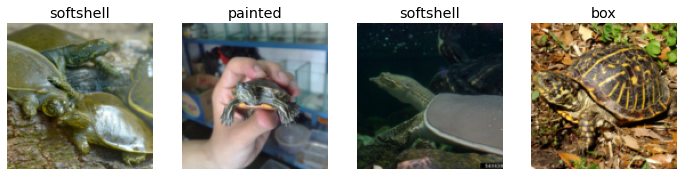

In [38]:
dls.valid.show_batch(max_n=4, nrows=1)

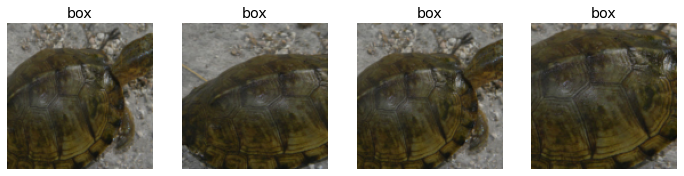

In [41]:
turtles = turtles.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = turtles.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

# Data Augmentation

Now we conduct some transformations on our data. This will result in a larger dataset with slight variations on the images already in our data.

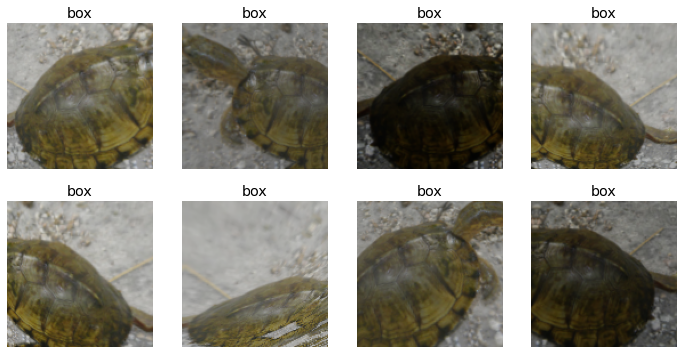

In [42]:
turtles = turtles.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = turtles.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

# Training our Model
Much of the above was just for demonstration. Now we will train the actual model. We will use RandomResizedCrop with somewhat larger images, and `aug_transform` with default settings.

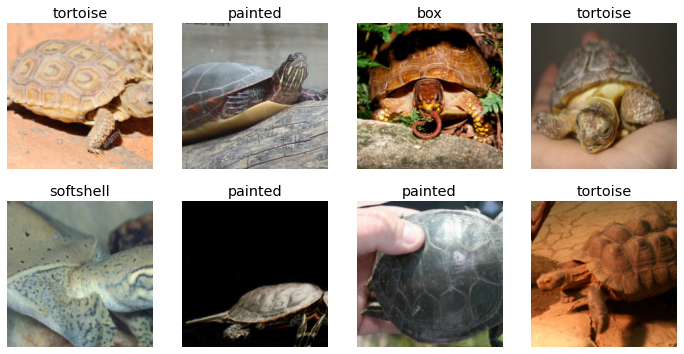

In [43]:
turtles = turtles.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = turtles.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2)

In [44]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/djliden91/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.790645,0.695464,0.230089,01:39


epoch,train_loss,valid_loss,error_rate,time
0,0.570889,0.238015,0.070796,02:45
1,0.422141,0.127614,0.053097,02:03
2,0.319913,0.092171,0.044248,02:14
3,0.249808,0.086542,0.035398,02:24


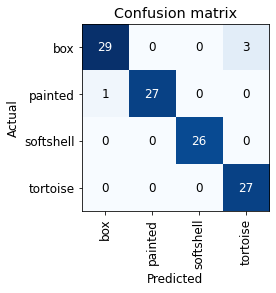

In [45]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Box turtles and tortoises are fairly closely related, so this isn't terribly surprising. Softshells look nothing like any of the other classes so I'm pleased that these were all classified properly.

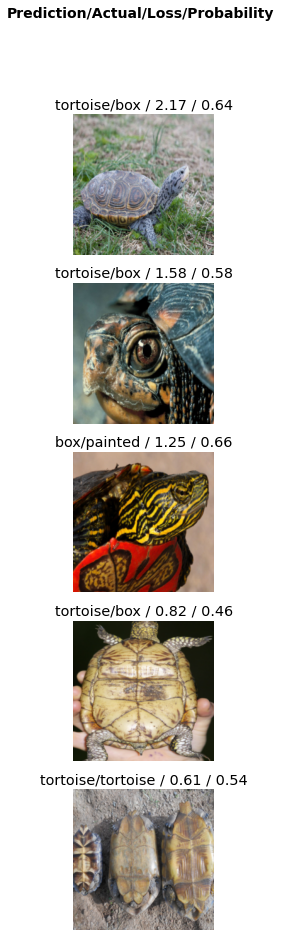

In [47]:
interp.plot_top_losses(5, nrows=5)

In [48]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [49]:
# Delete images we've identified as bad.
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

In [ ]:
# Refit the model now that we've removed some images
turtles = turtles.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = turtles.dataloaders(path)
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.863542,0.435724,0.159292,02:06


epoch,train_loss,valid_loss,error_rate,time
0,0.571790,0.292342,0.106195,02:47
1,0.407930,0.255585,0.079646,02:42
2,0.292686,0.238920,0.061947,03:14
